In [2]:
import sys

sys.path.append("../")

In [15]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256

def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return PIL.Image.open(io.BytesIO(resp.content))

def preprocess(img):
    if isinstance(img, torch.Tensor):
        s = min(img.shape[1:])
    else:
        s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

In [3]:
# This can be changed to a GPU, e.g. 'cuda:0'.
dev = torch.device('cpu')

# For faster load times, download these files locally and use the local paths instead.
enc = load_model("https://cdn.openai.com/dall-e/encoder.pkl", dev)
dec = load_model("https://cdn.openai.com/dall-e/decoder.pkl", dev)

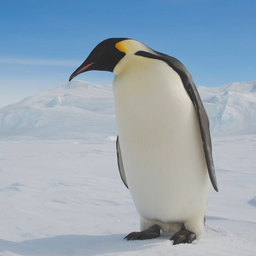

In [4]:
x = preprocess(download_image('https://assets.bwbx.io/images/users/iqjWHBFdfxIU/iKIWgaiJUtss/v2/1000x-1.jpg'))
display_markdown('Original image:')
display(T.ToPILImage(mode='RGB')(x[0]))

In [5]:
dec.blocks[1][2]
from torch import nn
nn.Upsample(scale_factor=2, mode='nearest', recompute_scale_factor=True).recompute_scale_factor

True

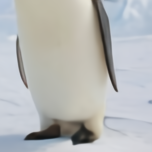

In [6]:
import torch.nn.functional as F

z_logits = enc(x[...,100:,100:])
z = torch.argmax(z_logits, axis=1)
z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()

x_stats = dec(z).float()
x_rec = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
x_rec = T.ToPILImage(mode='RGB')(x_rec[0])

display_markdown('Reconstructed image:')
display(x_rec)

In [7]:
def encode(x):
    z_logits = enc(x)
    z = torch.argmax(z_logits, axis=1)
    return z

def decode(z):
    z = F.one_hot(z, num_classes=enc.vocab_size).permute(0, 3, 1, 2).float()
    x_stats = dec(z).float()
    y = unmap_pixels(torch.sigmoid(x_stats[:, :3]))
    return y
    
def to_img(y):
    return T.ToPILImage(mode='RGB')(y)


In [8]:
dec

Decoder(
  (blocks): Sequential(
    (input): Conv2d(n_in=8192, n_out=128, kw=1, use_float16=False, device=device(type='cpu'), requires_grad=False)
    (group_1): Sequential(
      (block_1): DecoderBlock(
        (id_path): Conv2d(n_in=128, n_out=2048, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
        (res_path): Sequential(
          (relu_1): ReLU()
          (conv_1): Conv2d(n_in=128, n_out=512, kw=1, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_2): ReLU()
          (conv_2): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_3): ReLU()
          (conv_3): Conv2d(n_in=512, n_out=512, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
          (relu_4): ReLU()
          (conv_4): Conv2d(n_in=512, n_out=2048, kw=3, use_float16=True, device=device(type='cpu'), requires_grad=False)
        )
      )
      (block_2): DecoderBlock(
    

In [9]:
z = torch.argmax(z_logits, axis=1)

In [10]:
z.shape, x.shape, z

(torch.Size([1, 19, 19]),
 torch.Size([1, 3, 256, 256]),
 tensor([[[8099, 6767, 5374, 4786, 3853, 6351,  524,  817, 4405, 7261, 7751,
           1064, 7884, 1902, 7382, 7503, 1541, 6814, 7975],
          [1616,  455, 8010, 3716, 6022, 1334, 2693, 3532, 2317, 1066, 1712,
           5734, 5363, 3945, 4220, 1996, 3310, 2733, 1260],
          [ 336, 2158, 6764, 4037, 8010,  368, 3336, 1114, 6351, 6246, 2413,
            817,  912, 6972, 1027, 5774, 1081, 5955, 1703],
          [2505, 2073, 5177,  539,  165, 3580, 5263, 8191, 5780, 6943, 6392,
           7499, 2260, 2633, 3101,  678, 1804, 2834, 8163],
          [3472, 6856, 3530, 2249, 2228, 7285, 3177, 2693, 4037, 2053, 6896,
           2566, 7197, 2485, 6808, 3719, 3399, 3953, 6982],
          [ 691, 5234, 5660, 1363, 2196, 3132, 6882, 2276, 1562, 4024, 7329,
           3802, 3515, 1424, 5917, 5164, 6788,   70,  275],
          [4980, 3387, 2690, 7873, 7499,  524, 5177,  861, 6083, 3802, 8125,
           4230, 7740, 1519, 3957, 5313, 158

## MNIST

In [4]:
import random

In [5]:
import torchvision
mnist_data = torchvision.datasets.MNIST('data', download=True, transform=torchvision.transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 37491702.59it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88809159.70it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22738572.66it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 7855888.15it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [44]:
print(len(mnist_data))
for i, sample in enumerate(data_loader):
    if i % 10000 ==0:
        print(i)
    pass


60000
0
10000
20000
30000
40000
50000


In [6]:
img = random.choice(mnist_data)[0].repeat((1, 3, 1, 1))
#T.ToPILImage(mode="RGB")(img[0, ...].long())
img.shape

torch.Size([1, 3, 28, 28])

In [27]:
to_img(img[0])

In [28]:
to_img(decode(encode(img))[0])

In [16]:
import torchvision.transforms.v2 as transforms
img[0].shape, preprocess(transforms.Resize(512)(img[0]))

/home/doudou/Documents/Code/MultimodalDocumentUnderstanding/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


TypeError: 'builtin_function_or_method' object is not subscriptable